In [2]:
'''Numerical Study'''

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import numpy as np

import pandas as pd

import os,sys

import copy

import h3


import branca.colormap as cmp

from matplotlib.patches import Rectangle

## 01 Parameters

In [3]:
day='2020-12-01'

Commission_rate={'A':0.20,'B':0.25}

Order_df=pd.read_csv(os.path.join('Order_Result_'+str(day)+'.csv'))

Order_df=Order_df.drop(columns=['Unnamed: 0'])

Driver_df=pd.read_csv(os.path.join('Driver_Result_'+str(day)+'.csv'))

Driver_df=Driver_df.drop(columns=['Unnamed: 0'])

Record=pd.read_csv(os.path.join('Record_'+str(day)+'.csv'))

Record=Record.drop(columns=['Unnamed: 0'])


## 02 Overall statistics

In [13]:
print('Served orders :')

Order_num=Order_df.shape[0]

Served_num=Order_df.loc[(Order_df['Driver_id']!='Canceled')&(Order_df['Driver_id']!='Waiting')].shape[0]

Served_ratio=round(100*Served_num/Order_num,1)

print(Served_num)

print(Served_ratio)

print('Canceled orders :')

Canceled_num=Order_df.loc[(Order_df['Driver_id']=='Canceled')].shape[0]

Canceled_ratio=round(100*Canceled_num/Order_num,1)

print(Canceled_num)

print(Canceled_ratio)
    

'''Average Response time'''

Order_Stat=copy.deepcopy(Order_df.loc[(Order_df['Arrive_step']<=3600)&(Order_df['Driver_id']!='Canceled')&(Order_df['Driver_id']!='Waiting')])

Order_Stat['Response_time']=Order_Stat.apply(lambda x:(x['Response_step']-x['Arrive_step'])*10,axis=1)

Order_Stat=Order_Stat[['Order_id','Arrive_step','Response_step','Pickup_step','Response_time']]

print('Avg Response time:')

print(round(Order_Stat['Response_time'].mean(),1))



'''Average Pick-up time'''

Order_Stat=copy.deepcopy(Order_df.loc[(Order_df['Arrive_step']<=3600)])

Unserved_list=['Canceled','Waiting']

Order_Stat['Pickup_step']=Order_Stat.apply(lambda x:x['Response_step']+36 if x['Driver_id'] in Unserved_list else x['Pickup_step'],axis=1)

Order_Stat['Pickup_time']=Order_Stat.apply(lambda x:(x['Pickup_step']-x['Response_step'])*10,axis=1)

Order_Stat=Order_Stat[['Order_id','Arrive_step','Response_step','Pickup_step','Pickup_time']]

print('Avg Pick-up time:')

print(round(Order_Stat['Pickup_time'].mean(),1))



'''Average Occupied rate'''

Order_Stat=copy.deepcopy(Order_df.loc[(Order_df['Arrive_step']<=3600)&(Order_df['Driver_id']!='Canceled')&(Order_df['Driver_id']!='Waiting')])

def Get_duration(Pickup_step,Travel_time):

    if Pickup_step>3600:

        return 0

    elif Pickup_step+Travel_time>3600:

        return (3600-Pickup_step)*10

    else:

        return Travel_time*10

Order_Stat['duration']=Order_Stat.apply(lambda x:Get_duration(x['Pickup_step'],x['Travel_time']),axis=1)

Order_Stat=Order_Stat[['Driver_id','duration']].groupby('Driver_id').sum()


'''Statistics'''

Driver_Arrive=Driver_df.drop_duplicates(subset=['Driver_id'], keep='first')

Driver_Arrive=Driver_Arrive[['Driver_id','Step']]

Driver_Arrive=Driver_Arrive.rename(columns={'Step':'Arrive_Step'})

Driver_Arrive['Quit_Step']=3600

Driver_Arrive['Operation']=Driver_Arrive.apply(lambda x:(x['Quit_Step']-x['Arrive_Step'])*10,axis=1)

Occupied_ratio=Order_Stat['duration'].sum()/Driver_Arrive['Operation'].sum()

print('Avg Occupied ratio:')

print(Occupied_ratio*100)




Served orders :
3583
49.6
Canceled orders :
3608
49.9
Avg Response time:
20.7
Avg Pick-up time:
329.7
Avg Occupied ratio:
52.01900530667653


## 03 Platforms' performance

In [26]:
Platform_Count=Order_df.groupby('Platform').count()

Platform_Count=Platform_Count[['Order_id']]

Platform_Count['Platform']=Platform_Count.index

Platform_Count=Platform_Count[['Platform','Order_id']]

Platform_Count=Platform_Count.rename(columns={'Order_id':'Response'})

Platform_Count=Platform_Count.loc[Platform_Count['Platform']!='Null']

Platform_Count=Platform_Count.reset_index(drop=True)





Order_Platforms=Order_df.groupby('Platform').sum()

Order_Platforms=Order_Platforms[['Fare_A','Fare_B']]

Order_Platforms['Platform']=Order_Platforms.index

Order_Platforms=Order_Platforms.reset_index(drop=True)

Order_Platforms['Profits']=Order_Platforms.apply(lambda x:x['Fare_'+x['Platform']]*(1-Commission_rate[x['Platform']]) if x['Platform']!='Null' else 0,axis=1)

Order_Platforms['Wages']=Order_Platforms.apply(lambda x:x['Fare_'+x['Platform']]*(Commission_rate[x['Platform']]) if x['Platform']!='Null' else 0,axis=1)

Order_Platforms=Order_Platforms[['Platform','Profits','Wages']]

Order_Platforms=Order_Platforms.loc[Order_Platforms['Platform']!='Null']

Order_Platforms=Order_Platforms.reset_index(drop=True)



Order_Platforms=Order_Platforms.merge(Platform_Count,how='left', on='Platform')

Order_Platforms

,Platform,Profits,Wages,Response
0,A,15202.80,3800.70,2193
1,B,9036.15,3012.05,1390


## 05 Minute number of selection

In [27]:
inital_step=2520

def Get_minute(step):
    
    return int((step-inital_step)/6)

Record_Stat=copy.deepcopy(Record)

Record_Stat['minute']=Record_Stat.apply(lambda x:Get_minute(x['step']),axis=1)

Record_Stat=Record_Stat[['minute','Driver_selelction_A','Driver_selelction_B','Driver_selelction_Decline',\
                         'Passenger_selection_A','Passenger_selection_B','Passenger_selection_Decline',\
                         'Instant_match','Instant_cancel']].groupby('minute').sum()

Record_Stat['minute']=Record_Stat.index

Record_Stat=Record_Stat.reset_index(drop=True)

Record_Stat


,Driver_selelction_A,Driver_selelction_B,Driver_selelction_Decline,Passenger_selection_A,Passenger_selection_B,Passenger_selection_Decline,Instant_match,Instant_cancel,minute
0,29,13,7.0,9,33,7.0,7,0,0
1,45,32,15.0,22,39,31.0,16,8,1
2,43,36,11.0,19,38,33.0,18,2,2
3,72,33,15.0,16,54,50.0,16,8,3
4,44,16,12.0,14,40,18.0,9,10,4
...,...,...,...,...,...,...,...,...,...
175,37,21,9.0,27,36,34.0,21,36,175
176,49,10,13.0,16,51,14.0,21,30,176
177,50,16,11.0,26,49,17.0,27,18,177
178,49,13,6.0,24,45,21.0,20,19,178


C:\Users\yyan2437\AppData\Local\Temp/ipykernel_21184/1970600889.py:67: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax1.set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
C:\Users\yyan2437\AppData\Local\Temp/ipykernel_21184/1970600889.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


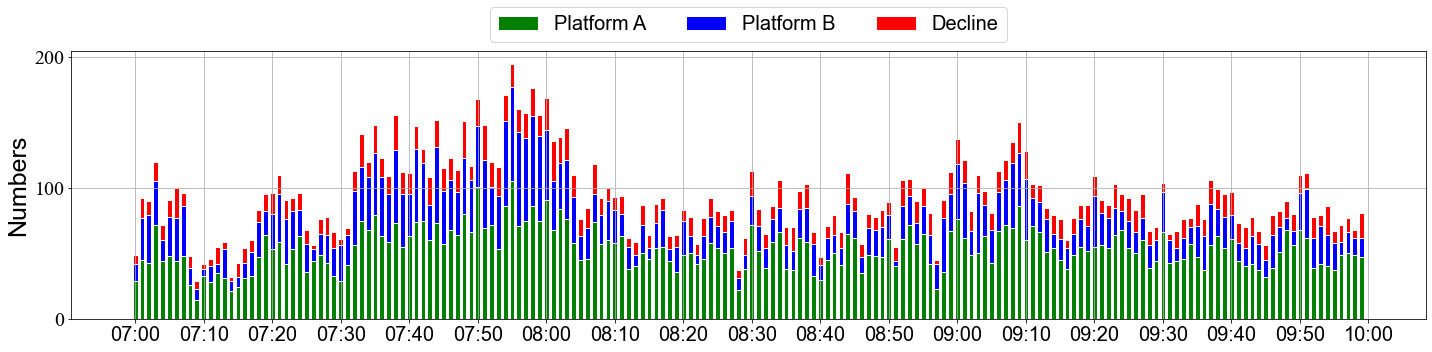

In [32]:
'''Plot Figure'''

figsize = 20,5

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(1,1,figsize=figsize)


labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]
    

'''Plot'''

cumulative=[0  for i in list(Record_Stat['minute'])]

ax1.bar(Record_Stat['minute'],\
        Record_Stat['Driver_selelction_A'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'g',\
        edgecolor = 'white',\
        label='Platform A')

cumulative=[list(Record_Stat['Driver_selelction_A'])[i]+cumulative[i] for i in list(Record_Stat['minute'])]

ax1.bar(Record_Stat['minute'],\
        Record_Stat['Driver_selelction_B'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'b',\
        edgecolor = 'white',\
        label='Platform B')

cumulative=[list(Record_Stat['Driver_selelction_B'])[i]+cumulative[i] for i in list(Record_Stat['minute'])]

ax1.bar(Record_Stat['minute'],\
        Record_Stat['Driver_selelction_Decline'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'red',\
        edgecolor = 'white',\
        label='Decline')
    


xmajorLocator   = MultipleLocator(10)

ax1.xaxis.set_major_locator(xmajorLocator)

ymajorLocator1   = MultipleLocator(100)

ax1.yaxis.set_major_locator(ymajorLocator1)

ax1.set_ylabel('Numbers',font_label)

ax1.grid()

ax1.set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
                        '08:00', '08:10','08:20','08:30','08:40','08:50',\
                        '09:00', '09:10','09:20','09:30','09:40','09:50','10:00'],font_legend)


ax1.legend(loc ='upper center',bbox_to_anchor=(0.5, 1.2),prop=font_legend,ncol=3)

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig(os.path.join('15Driver_selection.eps'), format='eps', dpi=1000, bbox_inches = 'tight')

plt.show()

C:\Users\yyan2437\AppData\Local\Temp/ipykernel_21184/766801278.py:68: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax1.set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
C:\Users\yyan2437\AppData\Local\Temp/ipykernel_21184/766801278.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


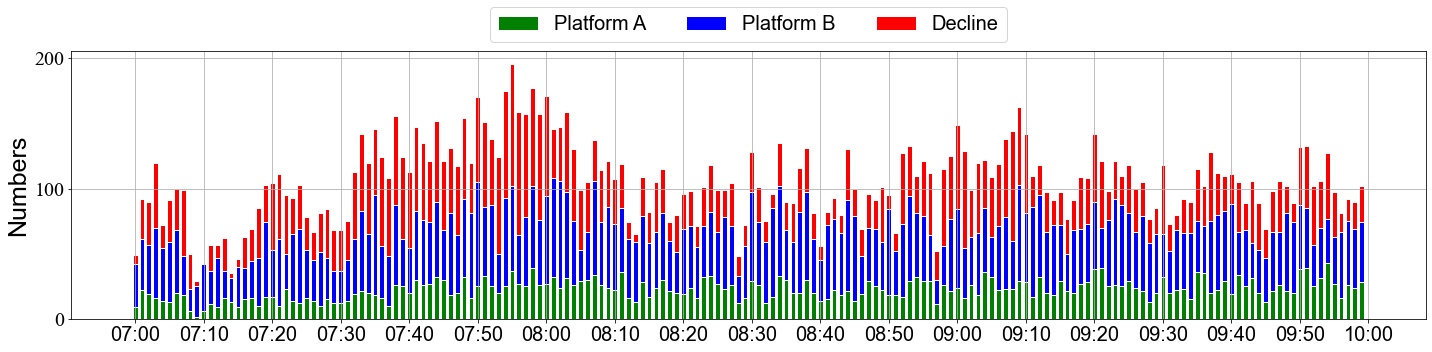

In [35]:
'''Plot Figure'''

figsize = 20,5

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(1,1,figsize=figsize)


labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]
    

'''Plot'''

cumulative=[0  for i in list(Record_Stat['minute'])]

ax1.bar(Record_Stat['minute'],\
        Record_Stat['Passenger_selection_A'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'g',\
        edgecolor = 'white',\
        label='Platform A')

cumulative=[list(Record_Stat['Passenger_selection_A'])[i]+cumulative[i] for i in list(Record_Stat['minute'])]

ax1.bar(Record_Stat['minute'],\
        Record_Stat['Passenger_selection_B'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'b',\
        edgecolor = 'white',\
        label='Platform B')

cumulative=[list(Record_Stat['Passenger_selection_B'])[i]+cumulative[i] for i in list(Record_Stat['minute'])]
    

ax1.bar(Record_Stat['minute'],\
        Record_Stat['Passenger_selection_Decline'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'red',\
        edgecolor = 'white',\
        label='Decline')
    


xmajorLocator   = MultipleLocator(10)

ax1.xaxis.set_major_locator(xmajorLocator)

ymajorLocator1   = MultipleLocator(100)

ax1.yaxis.set_major_locator(ymajorLocator1)

ax1.set_ylabel('Numbers',font_label)

ax1.grid()

ax1.set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
                        '08:00', '08:10','08:20','08:30','08:40','08:50',\
                        '09:00', '09:10','09:20','09:30','09:40','09:50','10:00'],font_legend)


ax1.legend(loc ='upper center',bbox_to_anchor=(0.5, 1.2),prop=font_legend,ncol=3)

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig(os.path.join('16Passenger_selection.eps'), format='eps', dpi=1000, bbox_inches = 'tight')

plt.show()

C:\Users\yyan2437\AppData\Local\Temp/ipykernel_21184/742828128.py:57: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ax1.set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
C:\Users\yyan2437\AppData\Local\Temp/ipykernel_21184/742828128.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


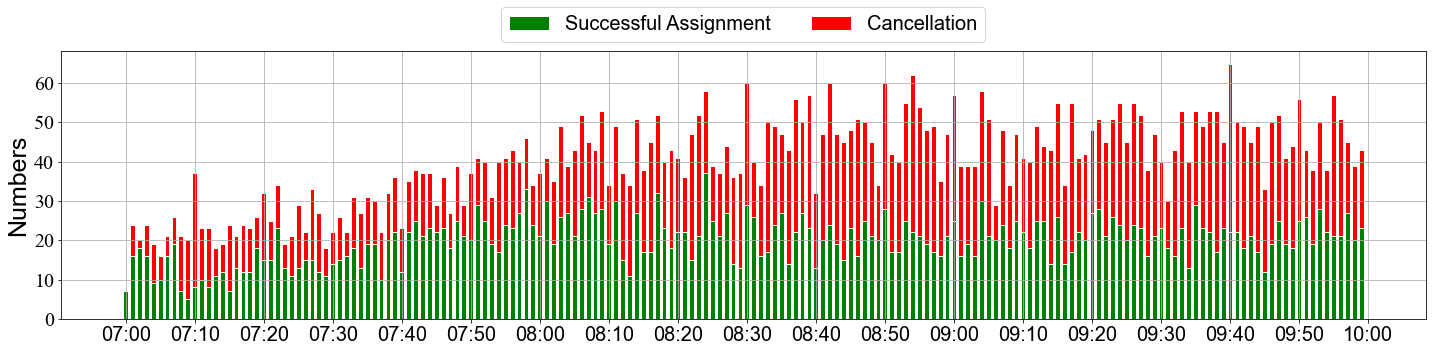

In [39]:
'''Plot Figure'''

figsize = 20,5

font_title = {'family' : 'Arial','weight' : 'normal','size': 40}

font_label = {'family' : 'Arial','weight' : 'normal','size': 25}

font_legend = {'family' : 'Arial','weight' : 'normal','size': 20}

figure, ax1 = plt.subplots(1,1,figsize=figsize)


labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]
    

'''Plot'''

cumulative=[0  for i in list(Record_Stat['minute'])]

ax1.bar(Record_Stat['minute'],\
        Record_Stat['Instant_match'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'g',\
        edgecolor = 'white',\
        label='Successful Assignment')

cumulative=[list(Record_Stat['Instant_match'])[i]+cumulative[i] for i in list(Record_Stat['minute'])]

ax1.bar(Record_Stat['minute'],\
        Record_Stat['Instant_cancel'],\
        bottom=cumulative,
        width = 0.7,\
        facecolor = 'red',\
        edgecolor = 'white',\
        label='Cancellation')
    


xmajorLocator   = MultipleLocator(10)

ax1.xaxis.set_major_locator(xmajorLocator)

ymajorLocator1   = MultipleLocator(10)

ax1.yaxis.set_major_locator(ymajorLocator1)

ax1.set_ylabel('Numbers',font_label)

ax1.grid()

ax1.set_xticklabels(['','07:00', '07:10','07:20','07:30','07:40','07:50',\
                        '08:00', '08:10','08:20','08:30','08:40','08:50',\
                        '09:00', '09:10','09:20','09:30','09:40','09:50','10:00'],font_legend)


ax1.legend(loc ='upper center',bbox_to_anchor=(0.5, 1.2),prop=font_legend,ncol=2)

plt.tight_layout()

current_fig = plt.gcf() # 'get current figure'

current_fig.savefig(os.path.join('17Successful_Assignment.eps'), format='eps', dpi=1000, bbox_inches = 'tight')

plt.show()